In [92]:
from drn_interactions.load import load_derived_generic, get_fig_dir, load_spikes, load_events
from drn_interactions.spikes import SpikesHandler, SpikesHandlerMulti

from drn_interactions.transforms import align_to_data_by
from drn_interactions.spikes import bin_spikes

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import seaborn as sns

from binit.bin import which_bin
import numpy as np

outdir = get_fig_dir() / "base_shock"
outdir.mkdir(exist_ok=True, parents=True)

In [2]:
# fast timescales

df_events = load_events("base_shock")
sessions = df_events.session_name.unique()
df_neurons = (
    load_derived_generic("clusters.csv")
    .merge(load_derived_generic("burst_features.csv"))
    .loc[lambda x: x.session_name.isin(sessions)][["neuron_id", "wf_3", "session_name"]]
)


In [3]:
df_events.columns

Index(['signal_name', 'session_name', 'timepoint_sample', 'group_name',
       'event_s'],
      dtype='object')

In [4]:
df_spikes = load_spikes("base_shock").merge(df_neurons)

In [6]:
df = align_to_data_by(
    df_spikes, 
    df_events,
    time_before_event=0.5,
    time_after_event=1.5,
    df_data_cell_col="neuron_id",
    df_data_group_col="session_name",
    df_events_group_colname="session_name",
    df_events_timestamp_col="event_s",
    df_data_time_col="spiketimes"
    )

c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  max_latency=max_latency,
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\df_grouping_utils\multiple_df_groupby.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_result["group"] = group
c:\users\roryl\repos\neurobox\neurobox\long_transforms.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

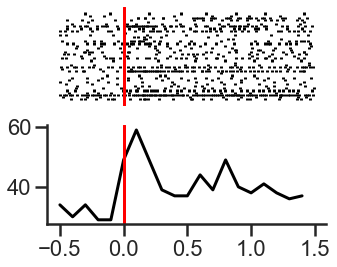

In [93]:
sns.set_theme(context="poster", style="ticks")

session_name = "hamilton_35"
trains = [g["aligned"].values for name, g in df.query("event == 1 and session_name == 'hamilton_35'").groupby("neuron_id")]

_, ax = plt.subplots(figsize=(5, 4), nrows=2, sharex=True)


ax[0].eventplot(trains, color="black", )
ax[0].axvline(0, color="red")
ax[0].set_yticks([])
ax[0].axis("off")
ax[0].set_xticks([-0.5, 0, 1.5])

pop_bin = bin_spikes(df.query("event == 1 and session_name == 'hamilton_35'"), t_before=-0.5, t_max=1.6, bin_width=0.1, spikes_col="aligned")
pop_bin.groupby("bin")["counts"].sum().plot(color="black", ax=ax[1])
ax[1].axvline(0, color="red")
ax[1].set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax[1].set_xlabel(None)
sns.despine(left=False)

plt.savefig(outdir / "population_single_trial.png", transparent=True, dpi=300)


In [77]:
df1 = df.query("session_name == 'hamilton_35'").copy()

bins = np.arange(-0.5, 1.6, 0.1)

df1["bin"] = which_bin(df1["aligned"].values, bins)
df1.groupby("bin").apply(len).divide(df1.event.max()).plot()

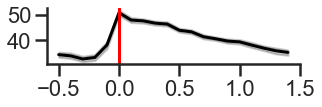

In [218]:
_, ax = plt.subplots(figsize=(5, 2), nrows=1, sharex=False)

df1.groupby(["bin", "event"]).apply(len).to_frame("counts").reset_index().pipe((sns.lineplot, "data"), x="bin", y="counts", ax=ax, color="black")

ax.axvline(0, color="red")
ax.set_xticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_xlabel(None)
ax.set_ylabel(None)
sns.despine(left=False)
plt.tight_layout()
plt.savefig(outdir / "population_trial_average.png", transparent=True, dpi=300)

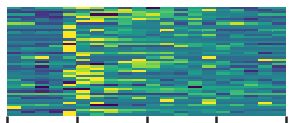

In [143]:
from scipy.stats import zscore
import matplotlib.ticker as ticker

_, ax = plt.subplots(figsize=(5, 2), nrows=1, sharex=True)

df2 = df1.groupby(["neuron_id", "event", "bin"]).apply(len).to_frame("counts").reset_index().merge(df_neurons[["neuron_id", "wf_3"]]).sort_values("wf_3").assign(bin=lambda x: x.bin.round(2))

df2 = df2.pivot_table(index="bin", values="counts", columns="neuron_id").fillna(0).apply(zscore)
sns.heatmap(df2.transpose(), cmap="viridis", center=0, robust=True, vmin=-2, vmax=2, yticklabels=[], ax =ax, cbar=False)
ax.set_ylabel(None)
ax.set_xlabel(None)

ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.savefig(outdir / "population_units_average.png", transparent=True, dpi=300)

In [147]:
from sklearn.feature_extraction.text import TfidfTransformer

In [185]:
sh = SpikesHandlerMulti(["pre", "base_shock", "post_base_shock"], bin_width=1, session_names=["hamilton_35"], t_start=0)

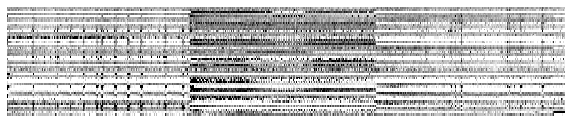

In [207]:
# sh = SpikesHandlerMulti(["pre", "base_shock", "post_base_shock"], bin_width=1, session_names=["hamilton_35"], t_start=0, )

df = sh.binned_piv.loc[lambda x: x.index > 980]
# vals = df.values.T
vals = TfidfTransformer().fit_transform(df.values.T).toarray()

_, ax = plt.subplots(figsize=(10, 2))
sns.heatmap(vals, cmap="Greys", ax=ax, cbar=False, xticklabels=False, yticklabels=False, robust=True)
# plt.savefig(outdir / "long_timescale_population_raster.png", transparent=True, dpi=300)

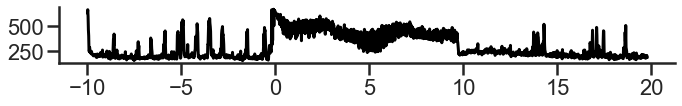

In [217]:
_, ax = plt.subplots(figsize=(10, 2))

df2 = df.reset_index().assign(bin=lambda x: x.bin.sub(x.bin.min()).divide(60).sub(10)).set_index("bin")
df2.transpose().sum().plot(color="black", ax=ax)
ax.set_xlabel(None)
sns.despine()


plt.tight_layout()
plt.savefig(outdir / "long_timescale_population_firing_rate.png", transparent=True, dpi=300)

In [210]:
df2

neuron_id,1839,1841,1842,1843,1844,1846,1847,1848,1850,1854,...,1897,1899,1900,1902,1903,1904,1906,1908,1909,1910
bin,,,,,,,,,,,,,,,,,,,,,
0.000000,18,3,0,12,54,7,9,0,2,5,...,55,18,0,5,4,14,4,100,1,5
0.016667,18,7,0,11,50,9,10,0,4,5,...,60,16,0,3,4,15,5,102,1,4
0.033333,18,5,0,11,45,7,11,0,2,4,...,62,16,0,4,4,12,4,87,4,4
0.050000,15,6,0,11,26,7,8,1,5,5,...,48,11,0,3,4,9,3,61,1,4
0.066667,17,7,0,10,20,8,8,0,3,4,...,37,9,0,3,6,8,4,41,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29.716667,13,3,0,7,0,5,8,0,1,2,...,30,1,1,3,4,1,3,19,29,0
29.733333,9,4,0,6,0,4,5,0,2,2,...,29,1,0,2,3,0,1,16,30,0
29.750000,14,3,0,7,0,3,7,0,1,2,...,31,1,0,2,3,0,1,17,29,0
